# NodeGAM by SKLearn Interface

This notebook shows how to train the NodeGAM and other GAMs through a sklearn-like interface.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from nodegam.sklearn import NodeGAMRegressor, NodeGAMClassifier
from nodegam.gams.MySpline import MySplineLogisticGAM, MySplineGAM
from nodegam.gams.MyEBM import MyExplainableBoostingClassifier, MyExplainableBoostingRegressor
from nodegam.gams.MyXGB import MyXGBOnehotClassifier, MyXGBOnehotRegressor
from nodegam.gams.MyBagging import MyBaggingClassifier, MyBaggingRegressor
from nodegam.utils import sigmoid_np, average_GAM_dfs
from nodegam.vis_utils import vis_GAM_effects

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import softmax
import torch
from sklearn.model_selection import train_test_split

## NodeGAMClassifier


We simulate a simple dataset with 3 features sampled from Uniform distributions from -5 to 5 i.e.

$x_0, x_1, x_2 \sim U[-5, 5]$

And the target is simulated as:

$y = x_0^2 + 2 * x_1 + sin(x_2)$

In binary classification, we go through a sigmoid and sample the target:

$\hat{y} = x_0^2 + 2 * x_1 + sin(x_2)$

$y \sim \text{Bern}(sigmoid(\hat{y}))$

We test 4 packages: NodeGAM, Spline, EBM, and XGB.

In [3]:
# Generate dataset
N = 25000
x1 = np.random.uniform(-5, 5, size=N)
x2 = np.random.uniform(-5, 5, size=N)
x3 = np.random.uniform(-5, 5, size=N)

f1 = lambda x: (x) ** 2 - 8
f2 = lambda x: x * 2
f3 = lambda x: np.sin(x)

y_prob = sigmoid_np(f1(x1) + f2(x2) + f3(x3))
# Sample
y = (np.random.random(N) < y_prob).astype(int)

X = pd.DataFrame(np.vstack([x1, x2, x3]).T)
X.shape, y.shape

((25000, 3), (25000,))

Ground Truth GAM graph

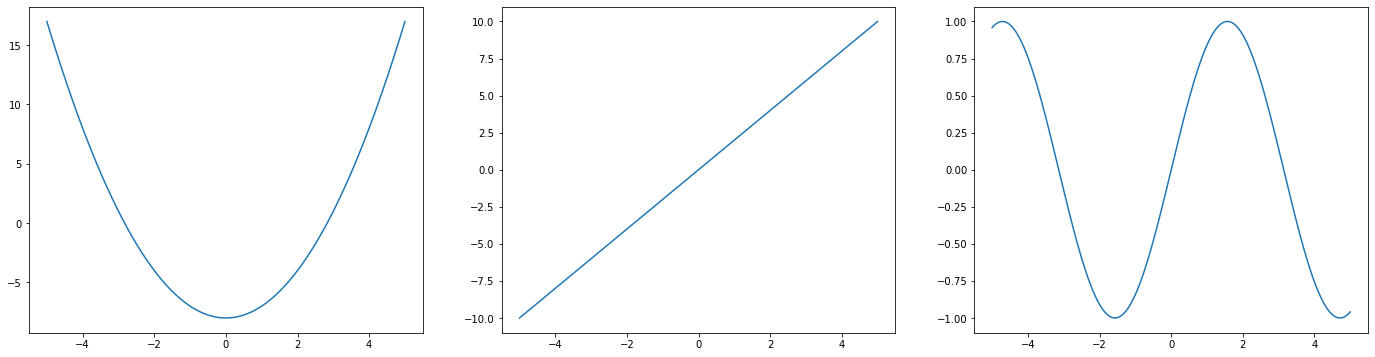

In [4]:
x = np.linspace(-5, 5, 1000)
fig, ax = plt.subplots(1, 3, figsize=(24, 6))
ax[0].plot(x, f1(x))
ax[1].plot(x, f2(x))
ax[2].plot(x, f3(x))

In [5]:
model = NodeGAMClassifier(
    in_features=3,
    objective='ce_loss',
)

In [6]:
record = model.fit(X, y)

/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/qhoptim/pyt/qhadam.py:133: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370116979/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg.mul_(beta1_adj).add_(1.0 - beta1_adj, d_p)


Steps	Train Err	Val Metric (ce_loss)
100	0.2245	0.3791
200	0.1474	0.3627
300	0.1585	0.3774
400	0.1507	0.3376
500	0.1527	0.3376
600	0.1624	0.2908
700	0.1245	0.2791
800	0.1667	0.1818
900	0.1516	0.1714
1000	0.1478	0.1607
1100	0.1518	0.1599
1200	0.1479	0.1512
1300	0.122	0.1473
1400	0.1393	0.1444
1500	0.15	0.1446
1600	0.1441	0.1459
1700	0.1317	0.1458
1800	0.1462	0.146
1900	0.1665	0.1481
2000	0.1471	0.1492
2100	0.1492	0.1458
2200	0.1613	0.1455
2300	0.1455	0.1453
LR: 1.00e-02 -> 2.00e-03
2400	0.1395	0.1435
2500	0.1373	0.1434
2600	0.131	0.1434
2700	0.1356	0.1439
2800	0.1436	0.1433
2900	0.1506	0.1434
3000	0.132	0.1435
3100	0.1535	0.1438
LR: 2.00e-03 -> 4.00e-04
3200	0.1458	0.1438
3300	0.1369	0.1441
3400	0.1413	0.1444
LR: 4.00e-04 -> 8.00e-05
3500	0.1278	0.1442
3600	0.1203	0.1441
3700	0.1276	0.1441
LR: 8.00e-05 -> 1.60e-05
3800	0.1492	0.1441
3900	0.1358	0.144
4000	0.135	0.1441
LR: 1.60e-05 -> 3.20e-06
4100	0.1443	0.144
4200	0.1236	0.144
4300	0.1264	0.144
LR: 3.20e-06 -> 1.00e-06
4400	0.1267	0.14

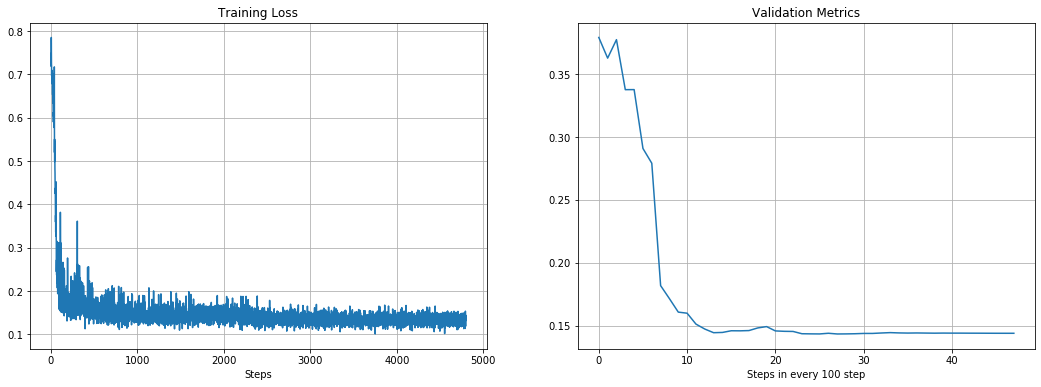

In [7]:
plt.figure(figsize=[18, 6])
plt.subplot(1, 2, 1)
plt.plot(record['train_losses'])
plt.title('Training Loss')
plt.xlabel('Steps')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(record['val_metrics'])
plt.title('Validation Metrics')
plt.xlabel('Steps in every 100 step')
plt.grid()
plt.show()

100%|██████████| 6/6 [00:00<00:00, 122.42it/s]

bin features 0 with uniq val 24990 to only 256
bin features 1 with uniq val 24991 to only 256
bin features 2 with uniq val 24994 to only 256
Finish "Run values through model" in 86ms
Finish "Extract values" in 53ms



100%|██████████| 7/7 [00:00<00:00, 39.14it/s]

Finish "Purify interactions to main effects" in 58ms
Finish "Center main effects" in 1ms
Finish "Construct table" in 183ms


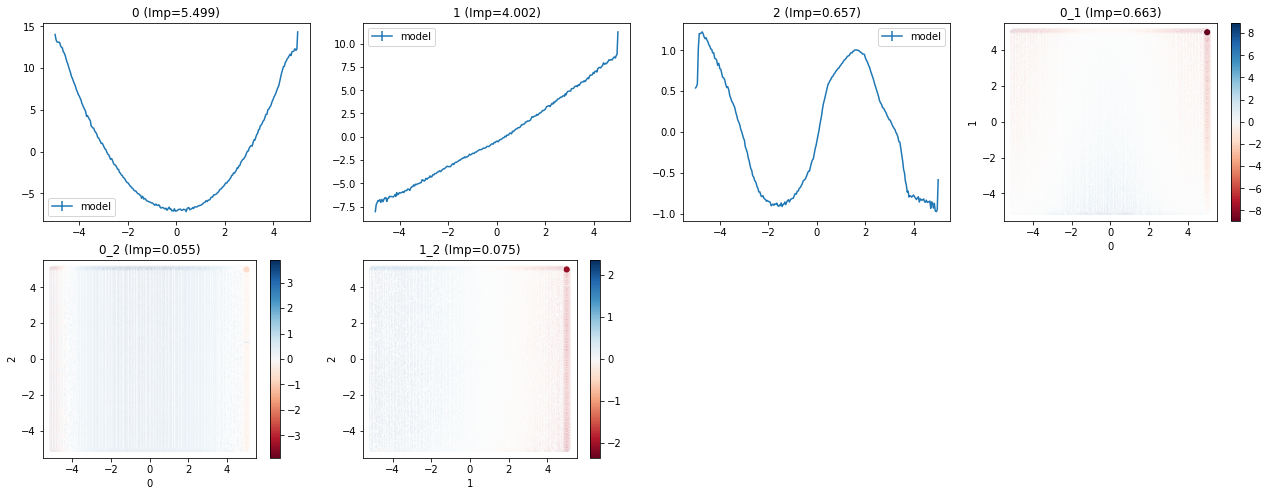

In [8]:
fig, axes, df = model.visualize(X)

Training multiple NodeGAMs with different seeds and take average to get error bar on the graph

In [9]:
model2 = NodeGAMClassifier(
    in_features=3,
    objective='ce_loss',
    verbose=0,
    seed=141,
)
record2 = model2.fit(X, y)

In [10]:
df = model.get_GAM_df(X)
df2 = model.get_GAM_df(X)

100%|██████████| 6/6 [00:00<00:00, 124.49it/s]

bin features 0 with uniq val 24990 to only 256
bin features 1 with uniq val 24991 to only 256
bin features 2 with uniq val 24994 to only 256
Finish "Run values through model" in 89ms
Finish "Extract values" in 52ms



 71%|███████▏  | 5/7 [00:00<00:00, 47.42it/s]

Finish "Purify interactions to main effects" in 59ms
Finish "Center main effects" in 1ms


100%|██████████| 6/6 [00:00<00:00, 125.69it/s]


Finish "Construct table" in 205ms
bin features 0 with uniq val 24990 to only 256
bin features 1 with uniq val 24991 to only 256
bin features 2 with uniq val 24994 to only 256
Finish "Run values through model" in 86ms
Finish "Extract values" in 51ms


 71%|███████▏  | 5/7 [00:00<00:00, 45.46it/s]

Finish "Purify interactions to main effects" in 59ms
Finish "Center main effects" in 1ms


100%|██████████| 7/7 [00:00<00:00, 34.01it/s]

Finish "Construct table" in 210ms


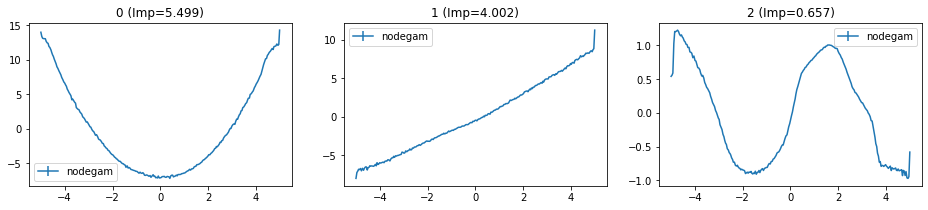

In [11]:
fig, ax = vis_GAM_effects(
    all_dfs={
        'nodegam': average_GAM_dfs([df, df2]),
    },
    top_interactions=0, # Only visualize main effects
    num_cols=3,
)

Ground Truth

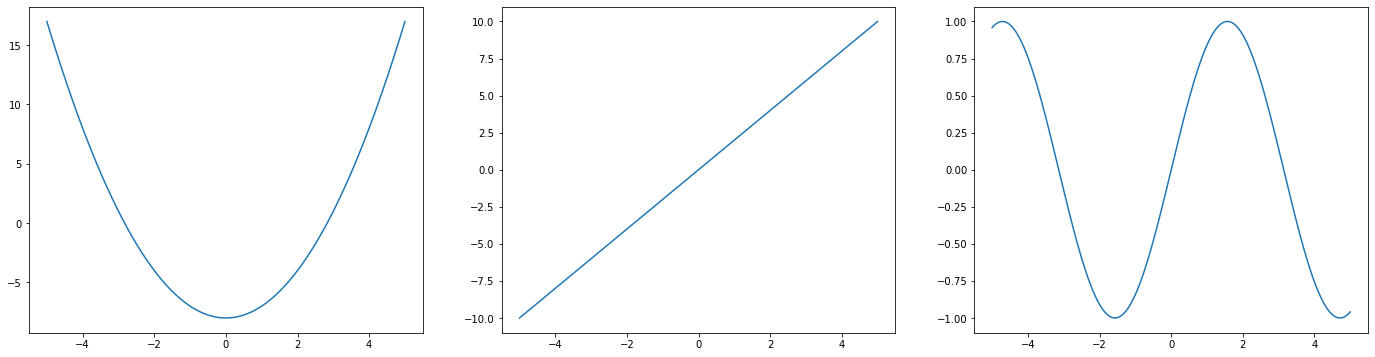

In [12]:
x = np.linspace(-5, 5, 1000)
fig, ax = plt.subplots(1, 3, figsize=(24, 6))
ax[0].plot(x, f1(x))
ax[1].plot(x, f2(x))
ax[2].plot(x, f3(x))

## NodeGAMClassifier with multiple classes

- Now it does not support the visualization for multi class yet, but it might be useful for people to benchmark its performance.

In [13]:
# Generate dataset
N = 25000
x1 = np.random.uniform(-5, 5, size=N)
x2 = np.random.uniform(-5, 5, size=N)
x3 = np.random.uniform(-5, 5, size=N)

f1 = lambda x: (x) ** 2 - 8
f2 = lambda x: x * 2
f3 = lambda x: np.sin(x)

y1_logit = f1(x1) + f2(x2) + f3(x3)
y2_logit = f1(x1) - 2*f2(x2) + f3(x3)
y3_logit = 2*f1(x1) - f2(x2) - f3(x3)

# Sample
y_logit = np.vstack([y1_logit, y2_logit, y3_logit]).T
y_prob = softmax(y_logit)
y = torch.multinomial(torch.from_numpy(y_prob), num_samples=1).squeeze(-1).numpy()

X = pd.DataFrame(np.vstack([x1, x2, x3]).T)
X.shape, y.shape

((25000, 3), (25000,))

In [14]:
X, X_test, y, y_test = train_test_split(X, y, random_state=1, train_size=0.8)

In [15]:
X.shape, X_test.shape

((20000, 3), (5000, 3))

In [16]:
model = NodeGAMClassifier(
    in_features=3,
    objective='error_rate', # or ce_loss
    num_classes=3,
)

In [17]:
record = model.fit(X, y)

Steps	Train Err	Val Metric (error_rate)
100	0.2797	0.1327
200	0.1601	0.1383
300	0.1555	0.143
400	0.159	0.138
500	0.2479	0.1337
600	0.1261	0.1107
700	0.1577	0.0733
800	0.2359	0.0567
900	0.1389	0.053
1000	0.1403	0.0523
1100	0.1638	0.0493
1200	0.1423	0.048
1300	0.136	0.0457
1400	0.1233	0.0433
1500	0.1343	0.0453
1600	0.13	0.0457
1700	0.2079	0.045
1800	0.1636	0.0463
1900	0.1248	0.0463
2000	0.1389	0.0467
2100	0.1265	0.0457
2200	0.194	0.0437
2300	0.1196	0.0433
LR: 1.00e-02 -> 2.00e-03
2400	0.1024	0.0427
2500	0.1215	0.0433
2600	0.116	0.0427
2700	0.0944	0.0423
2800	0.1232	0.043
2900	0.0977	0.0427
3000	0.1256	0.0423
LR: 2.00e-03 -> 4.00e-04
3100	0.1049	0.0427
3200	0.1073	0.0427
3300	0.1147	0.0417
3400	0.128	0.0417
3500	0.1206	0.042
3600	0.1175	0.0417
LR: 4.00e-04 -> 8.00e-05
3700	0.1076	0.0423
3800	0.1231	0.042
3900	0.0971	0.0423
LR: 8.00e-05 -> 1.60e-05
4000	0.1088	0.0427
4100	0.1348	0.043
4200	0.1058	0.043
LR: 1.60e-05 -> 3.20e-06
4300	0.1221	0.043
4400	0.1321	0.0423
4500	0.1169	0.042
LR: 3.20

In [18]:
prob = model.predict_proba(X_test)

In [19]:
pred = prob.argmax(axis=-1)
(pred == y_test).mean()

0.9422

94% Accuracy

## NodeGAMRegressor

In [20]:
# Generate dataset
N = 25000
x1 = np.random.uniform(-5, 5, size=N)
x2 = np.random.uniform(-5, 5, size=N)
x3 = np.random.uniform(-5, 5, size=N)

f1 = lambda x: (x) ** 2 - 8
f2 = lambda x: x * 2
f3 = lambda x: np.sin(x)

y = f1(x1) + f2(x2) + f3(x3)
X = pd.DataFrame(np.vstack([x1, x2, x3]).T)
X.shape, y.shape

((25000, 3), (25000,))

In [21]:
model = NodeGAMRegressor(
    in_features=3,
)

In [22]:
record = model.fit(X, y)

Normalize y. mean = 0.36123259974803457, std = 9.503690128994338
Steps	Train Err	Val Metric (mse)
100	0.4842	37.6852
200	0.0716	51.2287
300	0.0507	33.6227
400	0.0742	11.5541
500	0.1891	9.3334
600	0.0229	5.5246
700	0.0185	4.462
800	0.0233	4.3204
900	0.0096	4.3837
1000	0.0076	1.8555
1100	0.0059	1.0913
1200	0.0329	0.4921
1300	0.0227	0.3396
1400	0.0155	0.2285
1500	0.0136	0.2069
1600	0.0518	0.1222
1700	0.0224	0.2186
1800	0.0102	0.2478
1900	0.0118	0.2164
2000	0.0307	0.2165
2100	0.0175	0.2951
2200	0.0404	0.2609
2300	0.0122	0.3817
2400	0.0139	0.306
2500	0.046	0.2228
2600	0.0507	0.1977
LR: 1.00e-02 -> 2.00e-03
2700	0.0086	0.3239
2800	0.0178	0.3858
2900	0.01	0.3611
3000	0.0024	0.124
3100	0.0103	0.0437
3200	0.0054	0.0647
3300	0.006	0.0527
3400	0.0016	0.05
3500	0.0054	0.0552
3600	0.0041	0.0429
3700	0.0073	0.0319
3800	0.0027	0.0335
3900	0.0047	0.0206
4000	0.0015	0.0256
4100	0.0026	0.0384
4200	0.0045	0.038
4300	0.0068	0.0573
4400	0.0145	0.082
4500	0.0143	0.0576
LR: 2.00e-03 -> 4.00e-04
4600	0.009	0.

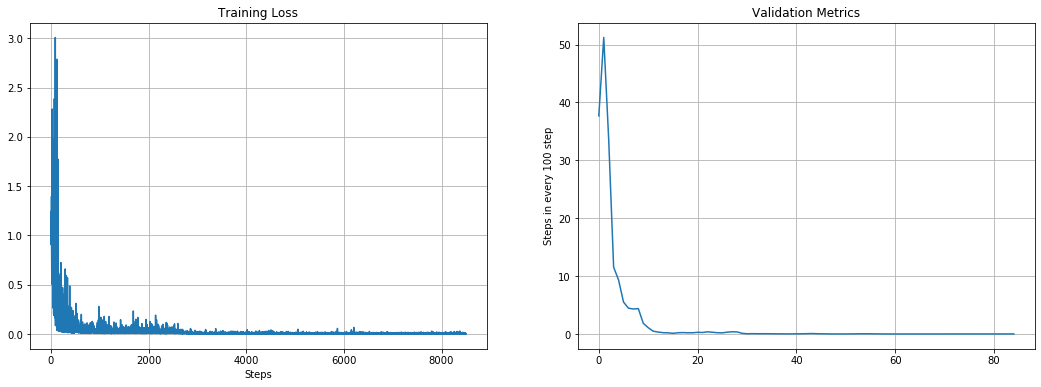

In [23]:
plt.figure(figsize=[18, 6])
plt.subplot(1, 2, 1)
plt.plot(record['train_losses'])
plt.title('Training Loss')
plt.xlabel('Steps')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(record['val_metrics'])
plt.title('Validation Metrics')
plt.ylabel('Steps in every 100 step')
plt.grid()
plt.show()

100%|██████████| 6/6 [00:00<00:00, 124.12it/s]

bin features 0 with uniq val 24996 to only 256
bin features 1 with uniq val 24994 to only 256
bin features 2 with uniq val 24992 to only 256
Finish "Run values through model" in 87ms
Finish "Extract values" in 52ms



 43%|████▎     | 3/7 [00:00<00:00, 29.55it/s]

Finish "Purify interactions to main effects" in 65ms
Finish "Center main effects" in 1ms


100%|██████████| 7/7 [00:00<00:00, 31.74it/s]


Finish "Construct table" in 225ms


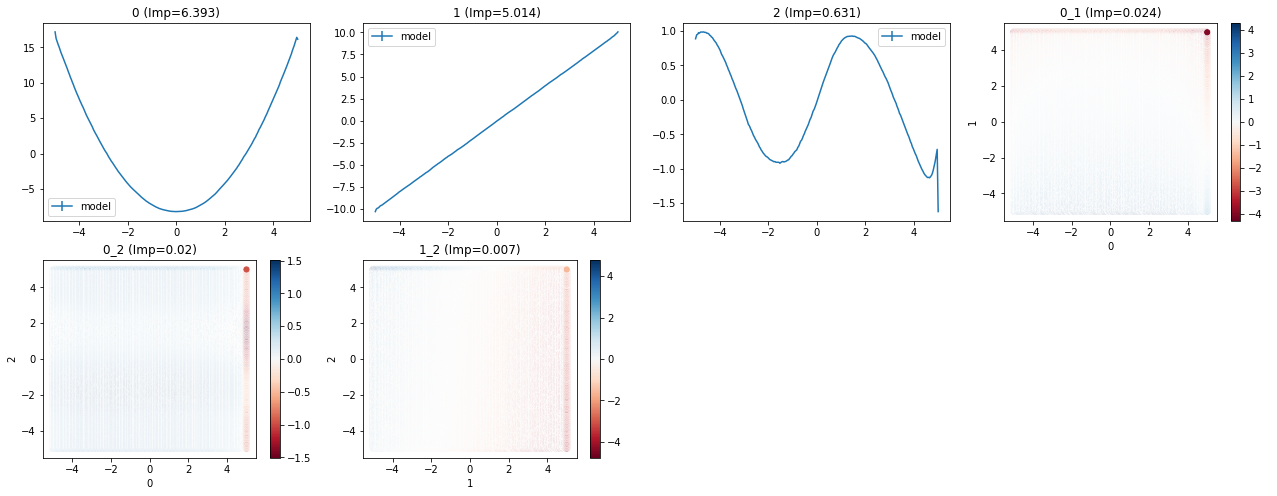

In [24]:
fig, axes, df = model.visualize(X)

Ground Truth

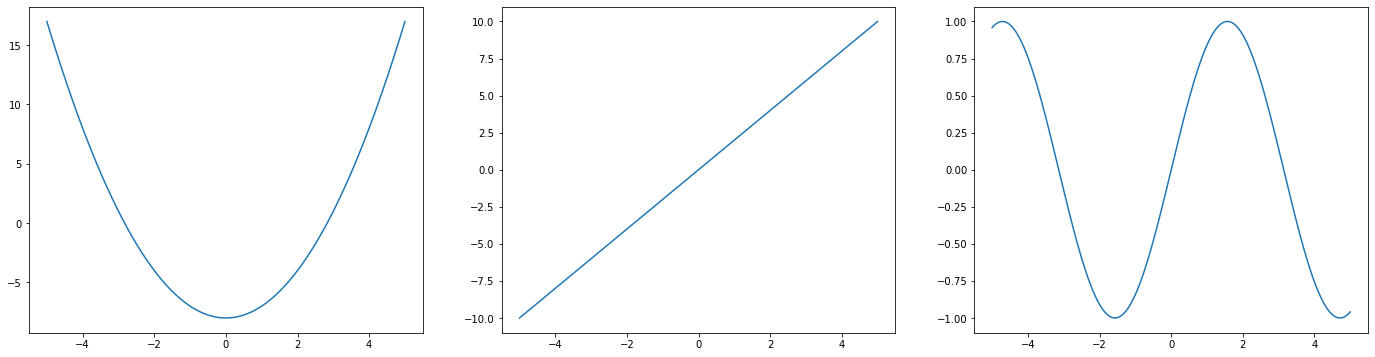

In [25]:
x = np.linspace(-5, 5, 1000)
fig, ax = plt.subplots(1, 3, figsize=(24, 6))
ax[0].plot(x, f1(x))
ax[1].plot(x, f2(x))
ax[2].plot(x, f3(x))

## Baseline Classifiers

In [26]:
# Generate dataset
N = 25000
x1 = np.random.uniform(-5, 5, size=N)
x2 = np.random.uniform(-5, 5, size=N)
x3 = np.random.uniform(-5, 5, size=N)

f1 = lambda x: (x) ** 2 - 8
f2 = lambda x: x * 2
f3 = lambda x: np.sin(x)

y_prob = sigmoid_np(f1(x1) + f2(x2) + f3(x3))
# Sample
y = (np.random.random(N) < y_prob).astype(int)

X = pd.DataFrame(np.vstack([x1, x2, x3]).T, columns=['f0', 'f1', 'f2'])
X.shape, y.shape

((25000, 3), (25000,))

In [27]:
spline = MySplineLogisticGAM()
bagged_spline = MyBaggingClassifier(base_estimator=spline, n_estimators=3)
bagged_spline.fit(X, y)

ebm = MyExplainableBoostingClassifier()
ebm.fit(X, y)

N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

search range from 0.001000 to 1000.000000


/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/pygam/links.py:149: RuntimeWarning: divide by zero encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/pygam/pygam.py:592: RuntimeWarning: invalid value encountered in multiply
  self.distribution.V(mu=mu) *
  6% (1 of 15) |#                        | Elapsed Time: 0:00:01 ETA:   0:00:25/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/pygam/links.py:149: RuntimeWarning: divide by zero encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/pygam/pygam.py:592: RuntimeWarning: invalid value encountered in multiply
  self.distribution.V(mu=mu) *
 13% (2 of 15) |###                      | Elapsed Time: 0:00:02 ETA:   0:00:16/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/pygam/links.py:149: RuntimeWarning: divide by zero encountered in true_

search range from 0.001000 to 1000.000000


/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/pygam/links.py:149: RuntimeWarning: divide by zero encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/pygam/pygam.py:592: RuntimeWarning: invalid value encountered in multiply
  self.distribution.V(mu=mu) *
  6% (1 of 15) |#                        | Elapsed Time: 0:00:01 ETA:   0:00:26/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/pygam/links.py:149: RuntimeWarning: divide by zero encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/pygam/pygam.py:592: RuntimeWarning: invalid value encountered in multiply
  self.distribution.V(mu=mu) *
 13% (2 of 15) |###                      | Elapsed Time: 0:00:02 ETA:   0:00:16/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/pygam/links.py:149: RuntimeWarning: divide by zero encountered in true_

search range from 0.001000 to 1000.000000


/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/pygam/links.py:149: RuntimeWarning: divide by zero encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/pygam/pygam.py:592: RuntimeWarning: invalid value encountered in multiply
  self.distribution.V(mu=mu) *
  6% (1 of 15) |#                        | Elapsed Time: 0:00:01 ETA:   0:00:25/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/pygam/links.py:149: RuntimeWarning: divide by zero encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/pygam/pygam.py:592: RuntimeWarning: invalid value encountered in multiply
  self.distribution.V(mu=mu) *
 13% (2 of 15) |###                      | Elapsed Time: 0:00:02 ETA:   0:00:16/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/pygam/links.py:149: RuntimeWarning: divide by zero encountered in true_

MyExplainableBoostingClassifier(feature_names=['f0', 'f1', 'f2', 'f0 x f1',
                                               'f1 x f2', 'f0 x f2'],
                                feature_types=['continuous', 'continuous',
                                               'continuous', 'interaction',
                                               'interaction', 'interaction'])

In [28]:
xgb_gam = MyXGBOnehotClassifier()
bagged_xgb = MyBaggingClassifier(base_estimator=xgb_gam, n_estimators=3)
bagged_xgb.fit(X, y)

/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-

MyBaggingClassifier(base_estimator=<nodegam.gams.MyXGB.MyXGBOnehotClassifier object at 0x7fa88218aa58>,
                    n_estimators=3)

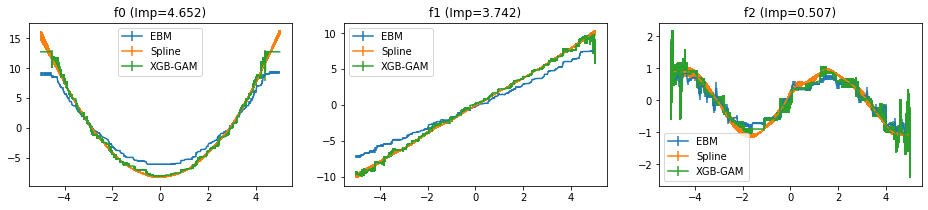

In [29]:
fig, ax = vis_GAM_effects(
    all_dfs={
        'EBM': ebm.get_GAM_df(),
        'Spline': bagged_spline.get_GAM_df(),
        'XGB-GAM': bagged_xgb.get_GAM_df(),
    },
    num_cols=3,
)

In [30]:
fig.savefig('example_gam_plot.png', dpi=300, bbox_inches='tight')

Ground Truth

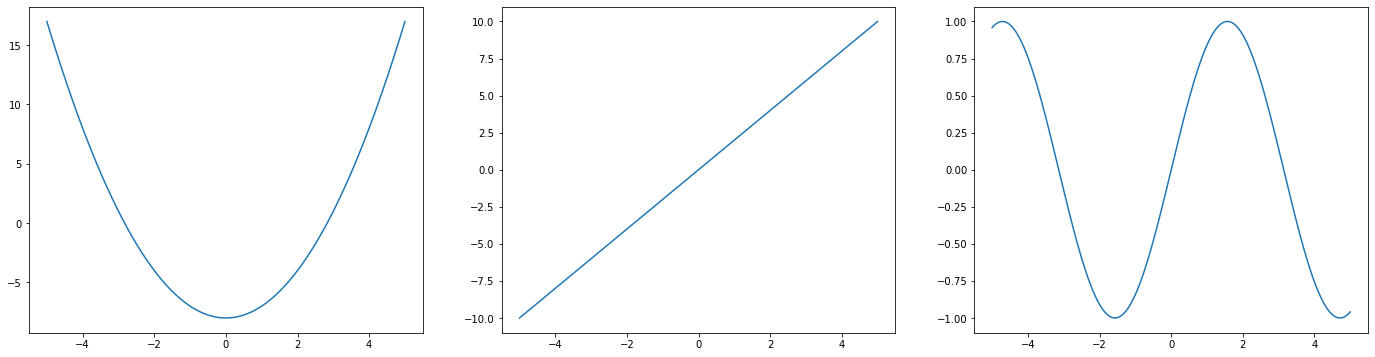

In [31]:
x = np.linspace(-5, 5, 1000)
fig, ax = plt.subplots(1, 3, figsize=(24, 6))
ax[0].plot(x, f1(x))
ax[1].plot(x, f2(x))
ax[2].plot(x, f3(x))

## Baseline Regressors

In [32]:
# Generate dataset
N = 25000
x1 = np.random.uniform(-5, 5, size=N)
x2 = np.random.uniform(-5, 5, size=N)
x3 = np.random.uniform(-5, 5, size=N)

f1 = lambda x: (x) ** 2 - 8
f2 = lambda x: x * 2
f3 = lambda x: np.sin(x)

y = f1(x1) + f2(x2) + f3(x3)
X = pd.DataFrame(np.vstack([x1, x2, x3]).T)
X.shape, y.shape

((25000, 3), (25000,))

In [ ]:
# spline = MySplineGAM()
# bagged_spline = MyBaggingRegressor(base_estimator=spline, n_estimators=3)
# bagged_spline.fit(X, y)

ebm = MyExplainableBoostingRegressor()
ebm.fit(X, y)

xgb_gam = MyXGBOnehotRegressor()
bagged_xgb = MyBaggingRegressor(base_estimator=xgb_gam, n_estimators=3)
bagged_xgb.fit(X, y)

Somehow Spline Regressor can not work. It produces a wierd error that I can not solve :(

In [ ]:
# spline = MySplineGAM()
# bagged_spline = MyBaggingRegressor(base_estimator=spline, n_estimators=3)
# bagged_spline.fit(X, y)

In [ ]:
fig, ax = vis_GAM_effects(
    all_dfs={
    'ebm': ebm.get_GAM_df(),
    'xgb': bagged_xgb.get_GAM_df(),
    # 'spline': bagged_spline.get_GAM_df(),
    },
    num_cols=3,
)

Ground Truth

In [ ]:
x = np.linspace(-5, 5, 1000)
fig, ax = plt.subplots(1, 3, figsize=(24, 6))
ax[0].plot(x, f1(x))
ax[1].plot(x, f2(x))
ax[2].plot(x, f3(x))